In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')
from scipy import stats
!pip3 install tensorflow_decision_forests
import tensorflow_decision_forests as tfdf
  #預測模型
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**放入資料**

In [ ]:
train_file_path = "/content/drive/MyDrive/Colab Notebooks/examples/House Prices - Advanced Regression Techniques/train.csv"
test_file_path = "/content/drive/MyDrive/Colab Notebooks/examples/House Prices - Advanced Regression Techniques/test.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))
dataset_df.info()

Full train dataset shape is (1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual  

In [ ]:
dataset_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# **相依矩陣**

<ipython-input-23-c218fb4055c9>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrMatrix = dataset_df.corr()


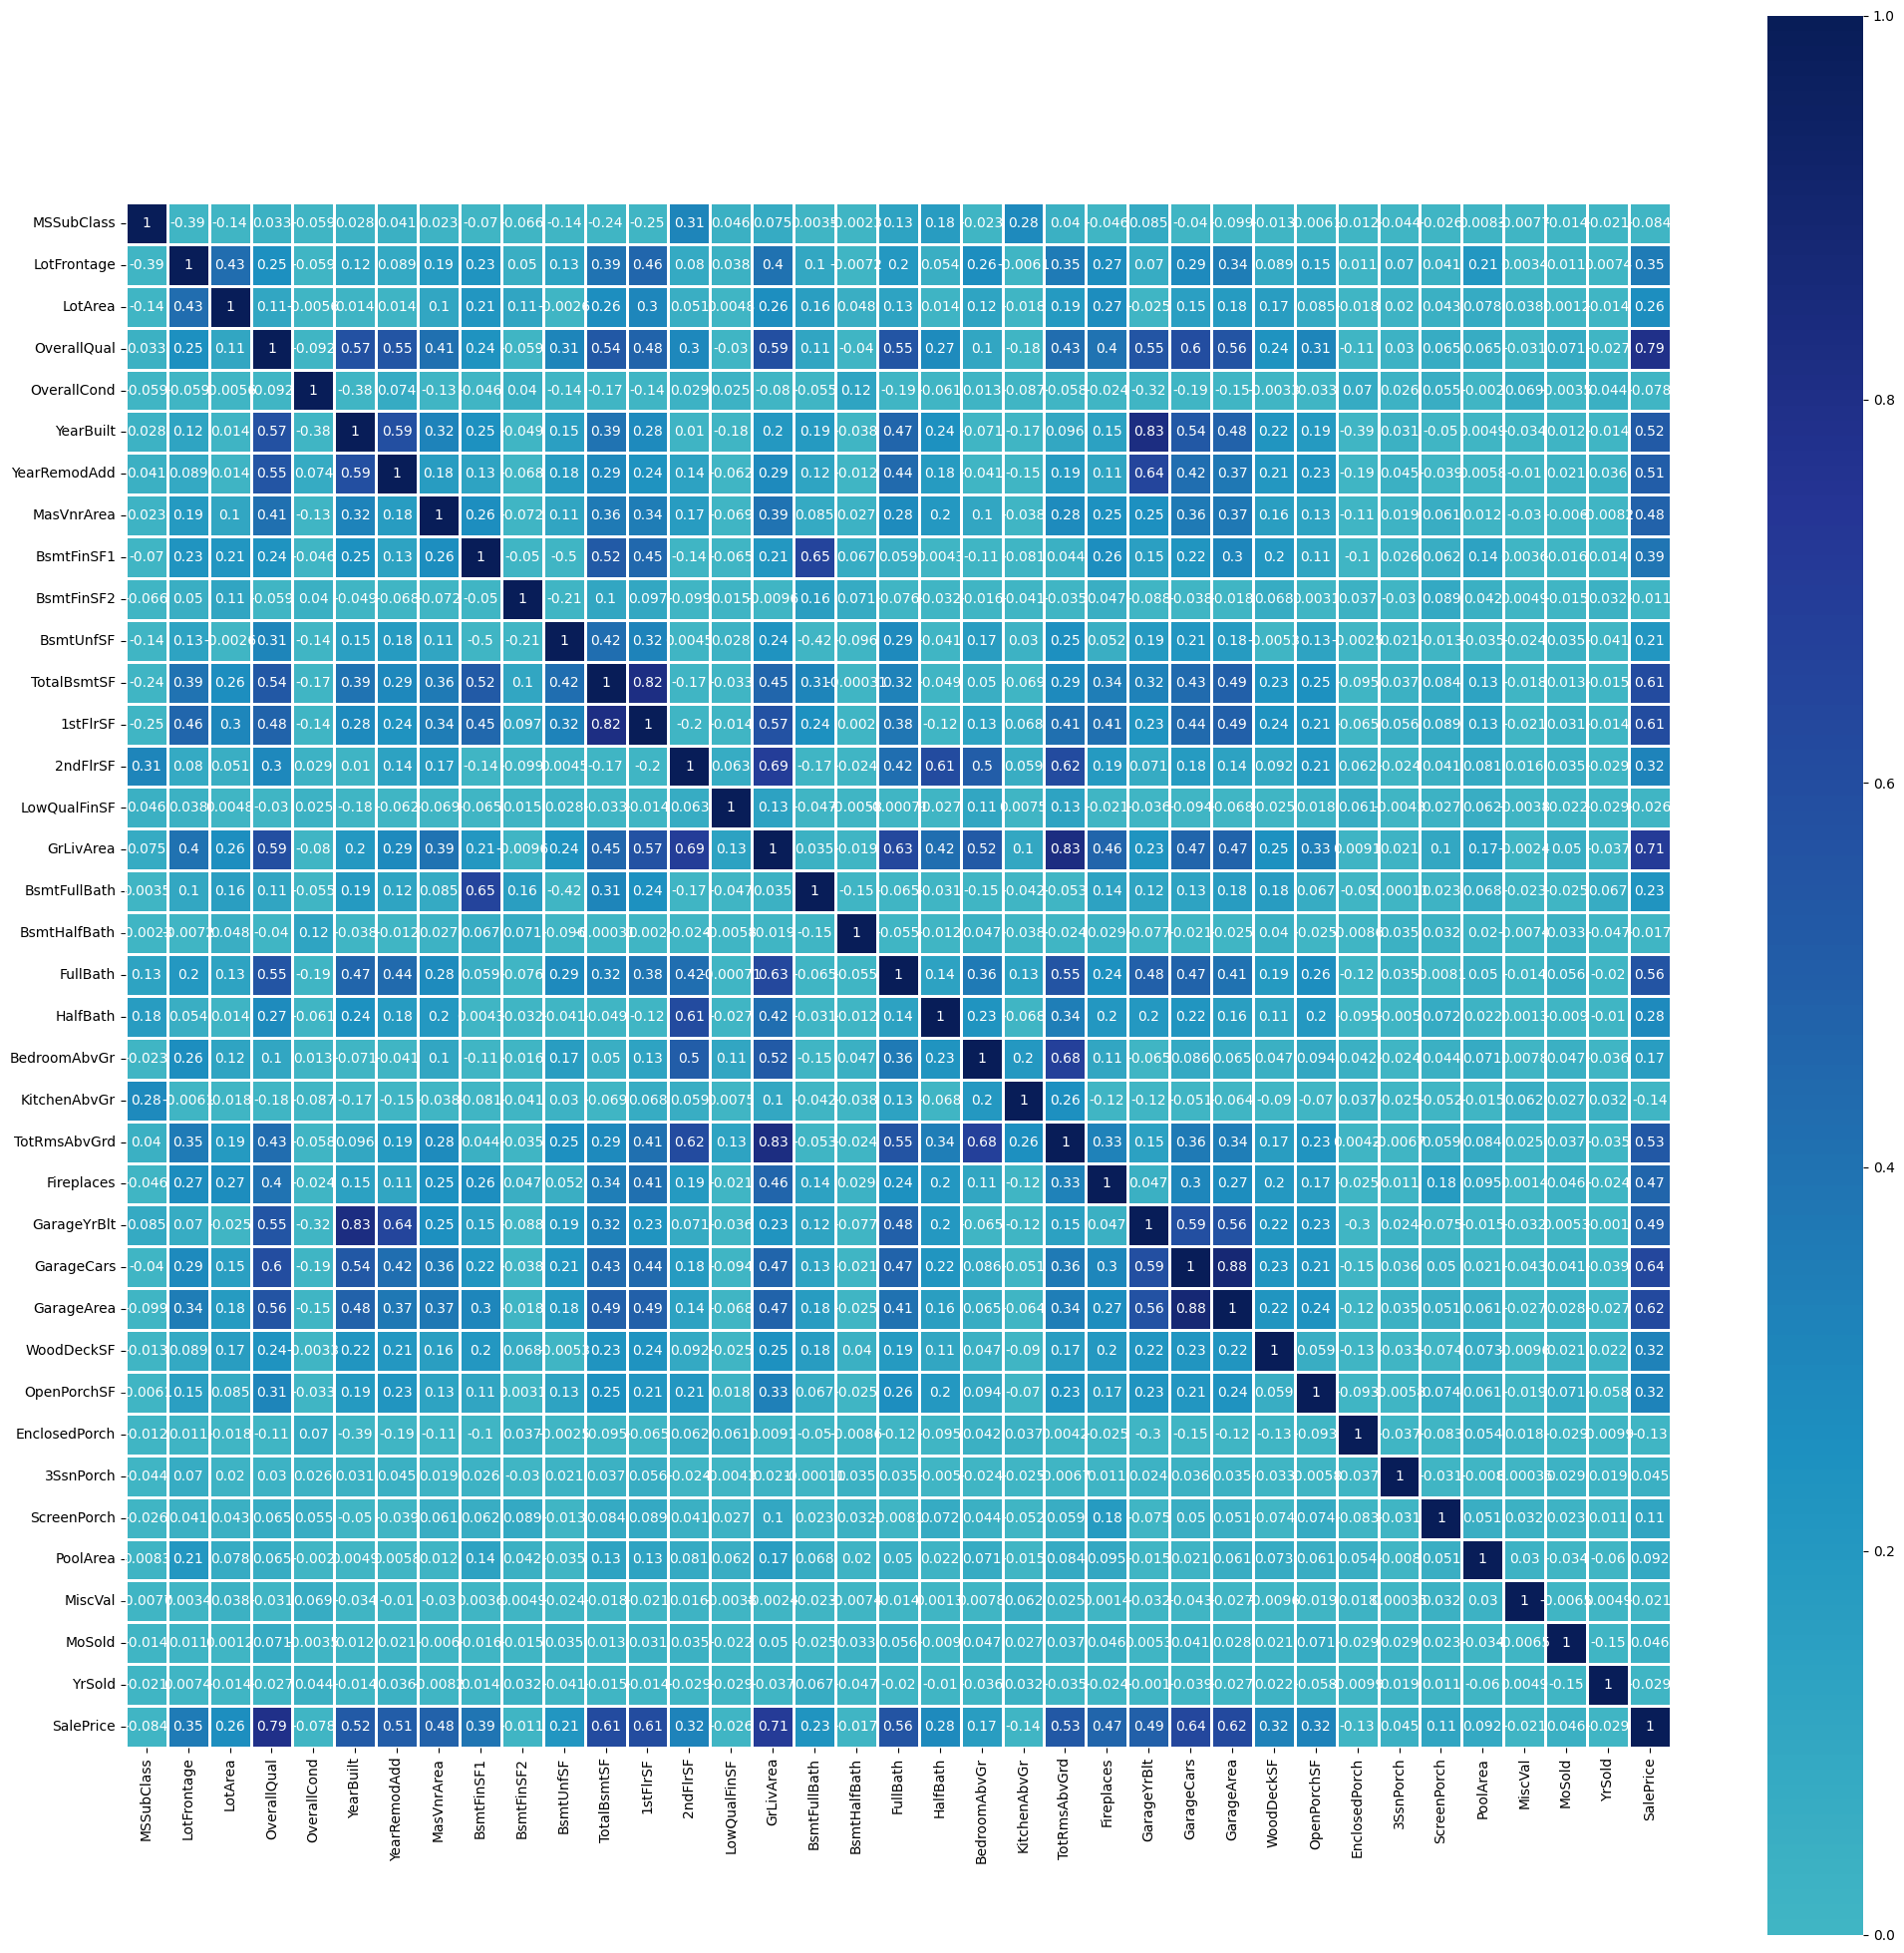

In [ ]:
corrMatrix = dataset_df.corr()
plt.figure(figsize=(25,25)) # Plotting the figure of required size
ax = sns.heatmap(corrMatrix, vmin=0, vmax=1, center=0, annot=True,
                 cmap="YlGnBu", linewidths = 1.0,
                 square=True)

plt.show()

# **觀察數據**

In [ ]:
dataset_df = dataset_df.drop('Id', axis=1)
dataset_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


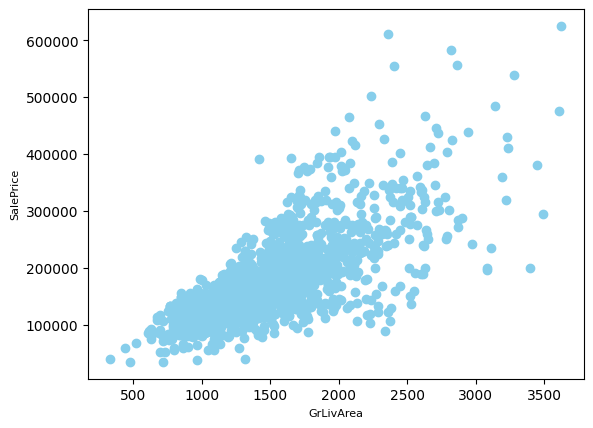

In [ ]:
dataset_df.drop(dataset_df[(dataset_df['GrLivArea']>4000)&(dataset_df['GrLivArea']<30000)].index,inplace=True)
fig, ax = plt.subplots()
ax.scatter(x = dataset_df['GrLivArea'], y = dataset_df['SalePrice'], c = "skyblue")
plt.ylabel('SalePrice', fontsize=8)
plt.xlabel('GrLivArea', fontsize=8)
plt.show()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<ipython-input-5-dc911a47893e>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});


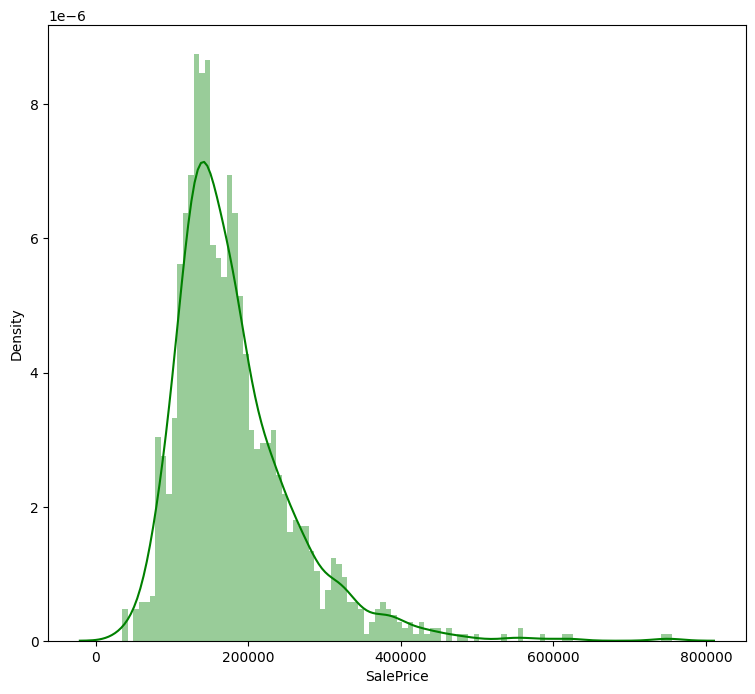

In [ ]:
print(dataset_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(dataset_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

# **整理數據**

In [ ]:
list(set(dataset_df.dtypes.tolist()))

[dtype('int64'), dtype('O'), dtype('float64')]

In [ ]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


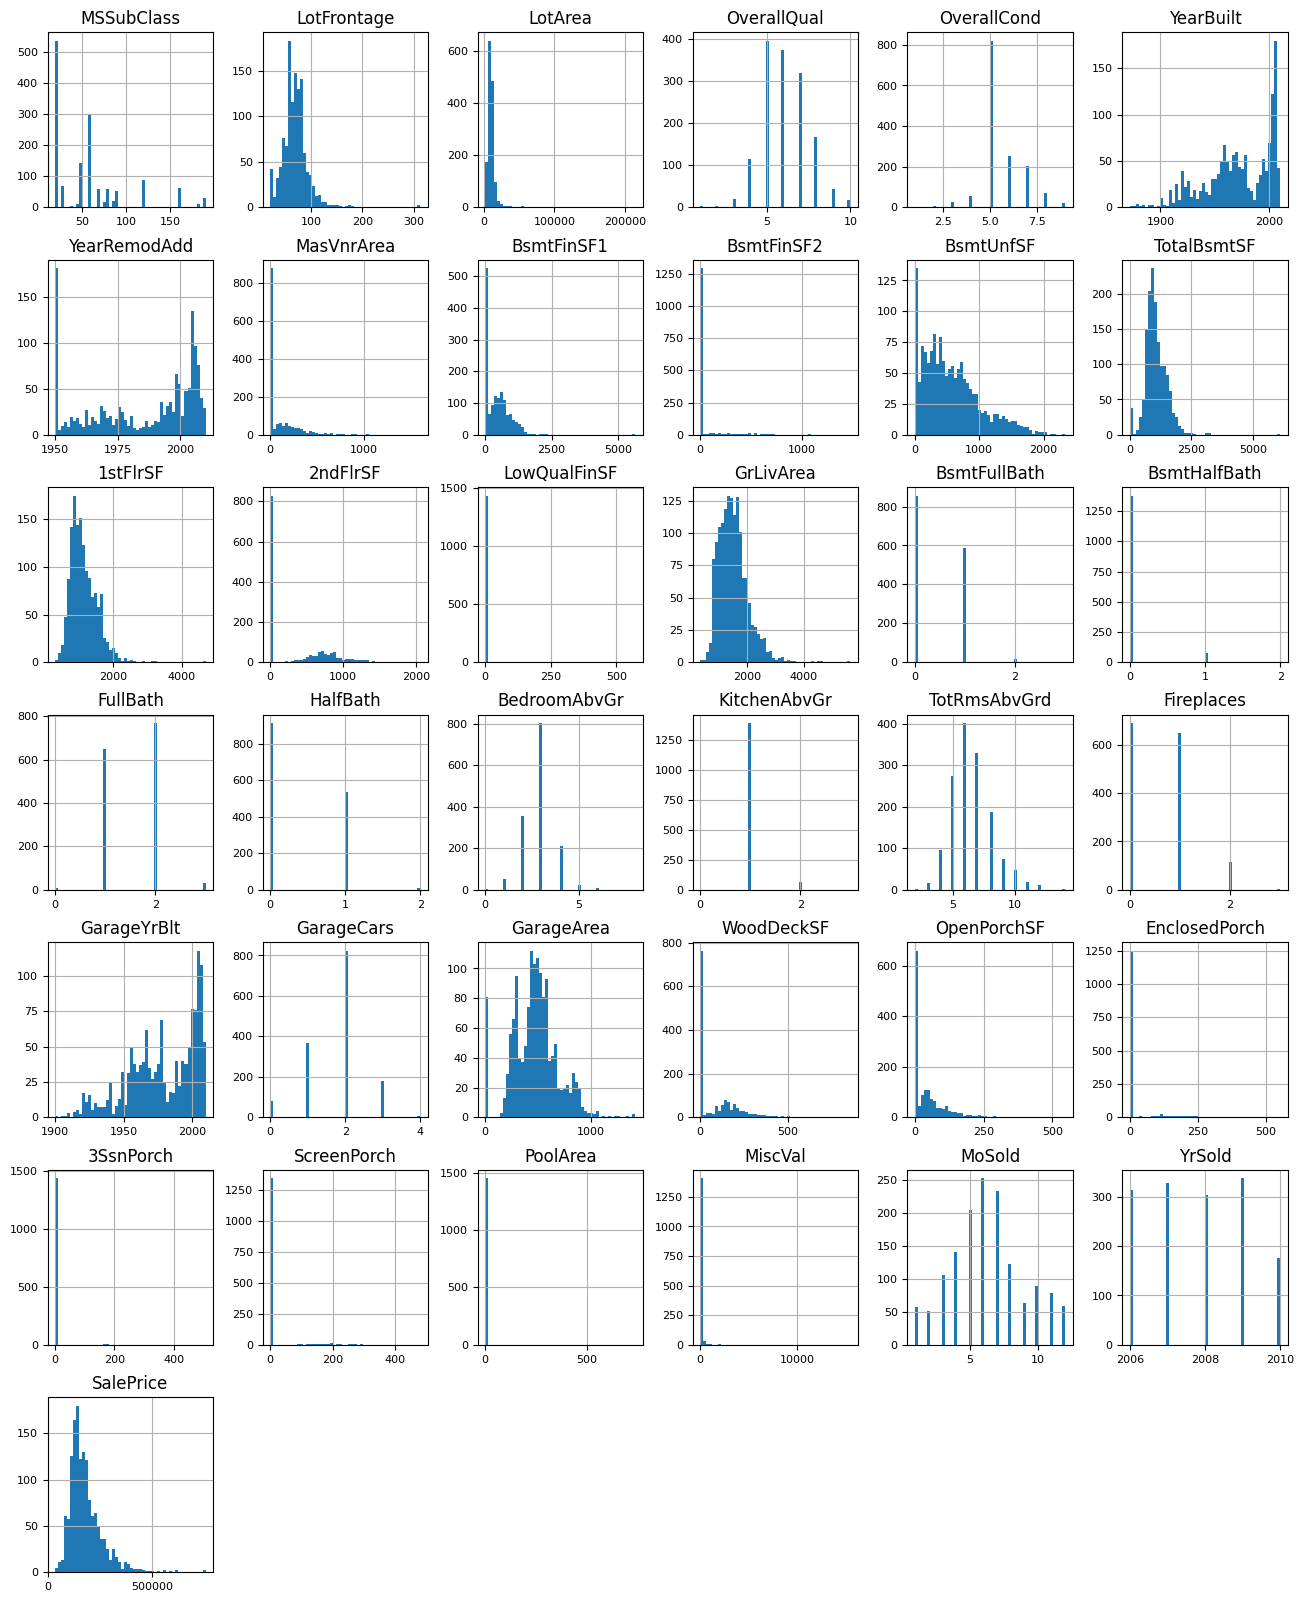

In [ ]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [ ]:
null_rows_idx = df_num.isnull().any(axis=1)
df_num.loc[null_rows_idx].head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
7,60,NaN,10382,7,6,1973,1973,240.0,859,32,...,235,204,228,0,0,0,350,11,2009,200000
12,20,NaN,12968,5,6,1962,1962,0.0,737,0,...,140,0,0,0,176,0,0,9,2008,144000
14,20,NaN,10920,6,5,1960,1960,212.0,733,0,...,0,213,176,0,0,0,0,5,2008,157000
16,20,NaN,11241,6,7,1970,1970,180.0,578,0,...,0,0,0,0,0,0,700,3,2010,149000
24,20,NaN,8246,5,8,1968,2001,0.0,188,668,...,406,90,0,0,0,0,0,5,2010,154000


In [ ]:
#用中位數填空
housing = df_num.copy()
median_01 = housing["LotFrontage"].median()
housing["LotFrontage"].fillna(median_01, inplace=True)
#housing.loc[null_rows_idx].head()

median_02 = housing["MasVnrArea"].median()
housing["MasVnrArea"].fillna(median_02, inplace=True)

median_03 = housing["GarageYrBlt"].median()
housing["GarageYrBlt"].fillna(median_03, inplace=True)

null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice


# **數據轉換(對數)與繪製Quantile Quantile Plot**

<ipython-input-28-9eabc75f3980>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_df['SalePrice_Log1p'],


Skewness: 0.065460
Kurtosis: 0.666423


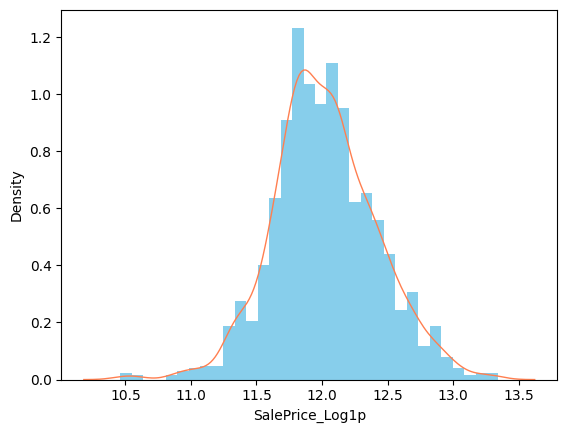

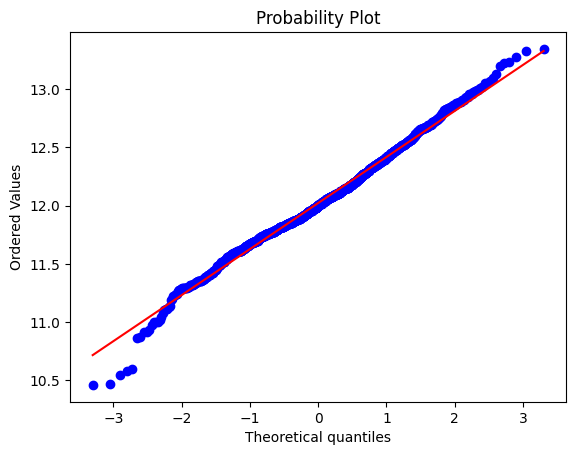

In [ ]:
dataset_df['SalePrice_Log1p'] = np.log1p(dataset_df['SalePrice'])

sns.distplot(dataset_df['SalePrice_Log1p'],
             kde_kws={"color": "coral", "lw": 1, "label": "KDE"},
             hist_kws={"histtype": "stepfilled", "linewidth": 3, "alpha": 1, "color": "skyblue"});

# 偏度與峰值(skewness and kurtosis)
print("Skewness: %f" % dataset_df['SalePrice_Log1p'].skew())
print("Kurtosis: %f" % dataset_df['SalePrice_Log1p'].kurt())

fig = plt.figure()
res = stats.probplot(dataset_df['SalePrice_Log1p'], plot=plt)
plt.show()

# **繪製矩陣**

In [ ]:
corrmat = df_num.corr()
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
mask

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

<Axes: >

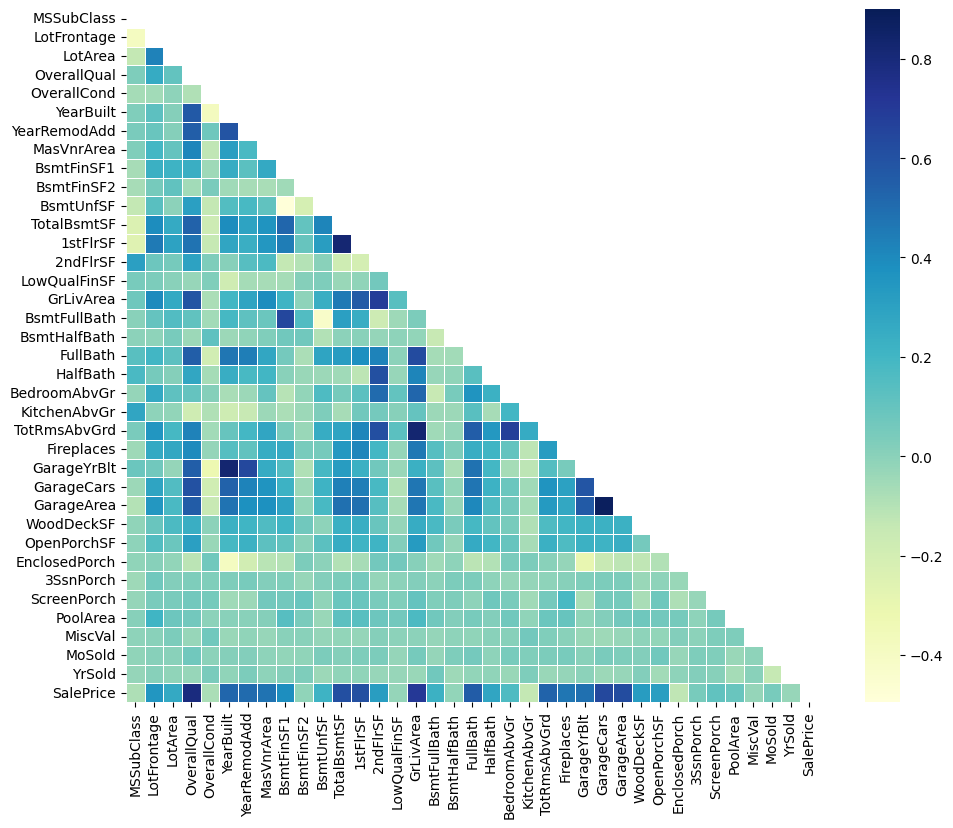

In [ ]:
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, mask=mask, linewidths=.5, vmax=0.9, square=True, cmap="YlGnBu")

In [ ]:
def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print(f"{len(train_ds_pd)} examples in training, {len(valid_ds_pd)} examples in testing.")

1041 examples in training, 419 examples in testing.


# **Ｒａｎｄｏｍ　ｆｏｒｅｓｔ　ｃｌａｓｓｉｆｉｃａｔｉｏｎ模型預測(投票)**

In [ ]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [ ]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"])

Use /tmp/tmpbk2git57 as temporary training directory


In [ ]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:05.756037. Found 1041 examples.
Training model...
Model trained in 0:00:03.532232
Compiling model...
Model compiled.


In [ ]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

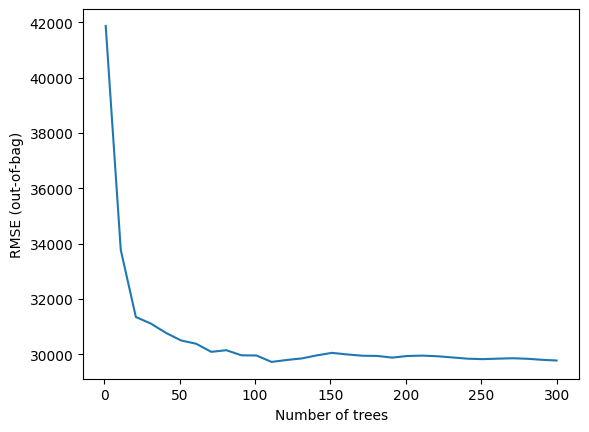

In [ ]:
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [ ]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1041, accuracy=None, loss=None, rmse=29768.73272970273, ndcg=None, aucs=None, auuc=None, qini=None)

In [ ]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 924ms/step - loss: 0.0000e+00 - mse: 905593024.0000
loss: 0.0000
mse: 905593024.0000


In [ ]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_NODES
	 SUM_SCORE
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT


In [ ]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 112.0),
 ("GarageCars" (1; #32), 54.0),
 ("ExterQual" (4; #22), 48.0),
 ("Neighborhood" (4; #59), 38.0),
 ("GrLivArea" (1; #38), 16.0),
 ("YearBuilt" (1; #76), 13.0),
 ("KitchenQual" (4; #44), 7.0),
 ("TotalBsmtSF" (1; #73), 6.0),
 ("1stFlrSF" (1; #0), 2.0),
 ("BsmtQual" (4; #14), 2.0),
 ("GarageArea" (1; #31), 2.0)]

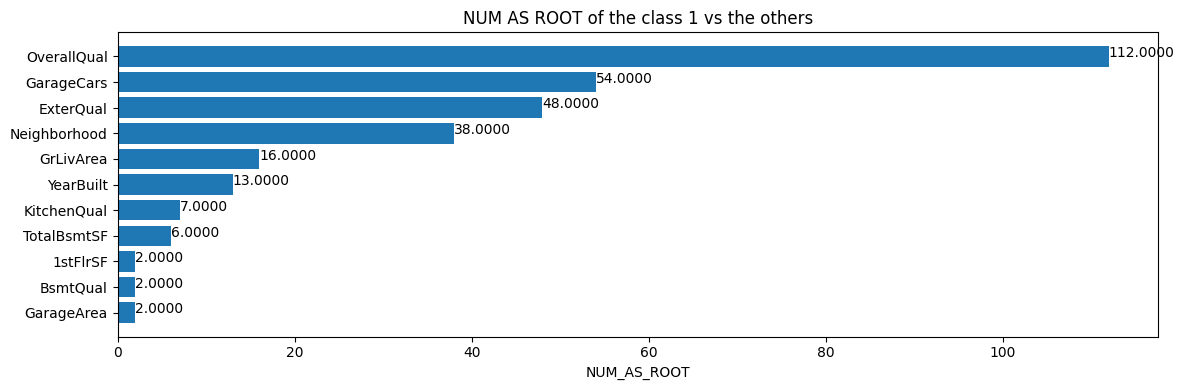

In [ ]:
plt.figure(figsize=(12, 4))

variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]

feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

In [ ]:
test_file_path = "/content/drive/MyDrive/Colab Notebooks/examples/House Prices - Advanced Regression Techniques/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
            'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 1s 38ms/step


,Id,SalePrice
0,1461,128987.476562
1,1462,150014.625000
2,1463,178088.125000
3,1464,181942.375000
4,1465,189312.687500


In [ ]:
sample_submission_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/examples/House Prices - Advanced Regression Techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
sample_submission_df.to_csv('/content/drive/MyDrive/Colab Notebooks/examples/House Prices - Advanced Regression Techniques/submission.csv', index=False)
sample_submission_df.head()

2/2 [==============================] - 0s 24ms/step


,Id,SalePrice
0,1461,128987.476562
1,1462,150014.625000
2,1463,178088.125000
3,1464,181942.375000
4,1465,189312.687500


# **Validation function(交叉驗證 計算MSE)**




In [ ]:
size_train_df = dataset_df.shape[0]
size_test_df = test_data.shape[0]
train = housing[:size_train_df]
test = housing[size_train_df:]

size_train_df =dataset_df.shape[0]
size_test_df = test_data.shape[0]
target_variable = dataset_df['SalePrice_Log1p'].values

In [ ]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, target_variable, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

# **LASSO Regression**

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.3887 (0.0471)



# **Kernel Ridge Regression**

In [ ]:
KRR = make_pipeline(RobustScaler(), KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5))
score = rmsle_cv(KRR)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 1.4317 (1.4100)



# **Elastic Net Regression**

In [ ]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.3887 (0.0471)



# **Gradient Boosting Regression**

In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5)

score = rmsle_cv(GBoost)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.4339 (0.0587)



# **XGBoost(取後不放回)**

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

score = rmsle_cv(model_xgb)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:02:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:02:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:02:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:02:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:02:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarn


Lasso score: 0.4270 (0.0537)



# **LightGBM**

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv(model_lgb)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319